# NicheVI for representing cells and their environment in spatial transcriptomics
In this tutorial, we go through the steps of training NicheVI, a deep generative model that leverages both cell-intrinsic and neighboring gene expression profiles to produce stochastic embeddings of cell states as well as normalized gene expression profiles. We show how to obtain informative fine-grained partitions of cells that reflects both their internal state and the surrounding tissue and use the generative model to test hypotheses of differential expression between tissue niches.

Plan for this tutorial:

1. Loading the data
2. Training a NicheVI model
3. Visualizing the latent space
4. Perform DE analysis across niches

In [1]:
# Install from GitHub for now
!pip install --quiet scvi-colab
!pip install --quiet adjustText
from scvi_colab import install

install()

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import colorcet as cc  # type: ignore

In [3]:
import os
import tempfile

import numpy as np  # type: ignore
import scanpy as sc  # type: ignore
import scvi  # type: ignore
from rich import print  # type: ignore

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Impor

Last run with scvi-tools version: 1.3.0

In [4]:
# Quickly check the correct folder is used.
scvi.__file__

'/home/nathanl/scvi-tools-main/src/scvi/__init__.py'

## Data loading

In this tutorial we load a human breast cancer section, generated with [10X Xenium](https://www.nature.com/articles/s41467-023-43458-x). 
The cell segmentation originally performed on this data resulted in many erroneously assigned transcripts and therefore re-segmented the cells using the [ProSeg](https://www.biorxiv.org/content/10.1101/2024.04.25.591218v1) algorithm, which is a scalable algorithm for transcriptome-informed segmentation.

In [5]:
adata_path = os.path.join(save_dir.name, "xenium_tutorial.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/53178338",
)
adata

  0%|          | 0.00/1.11G [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 117305 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 'cell_type'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca'
    obsm: 'X_pca', 'X_scANVI', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

The authors identified distinct tumor domains in this specimen, corresponding to in situ ductal carcinoma (DCIS) and invasive tumor:

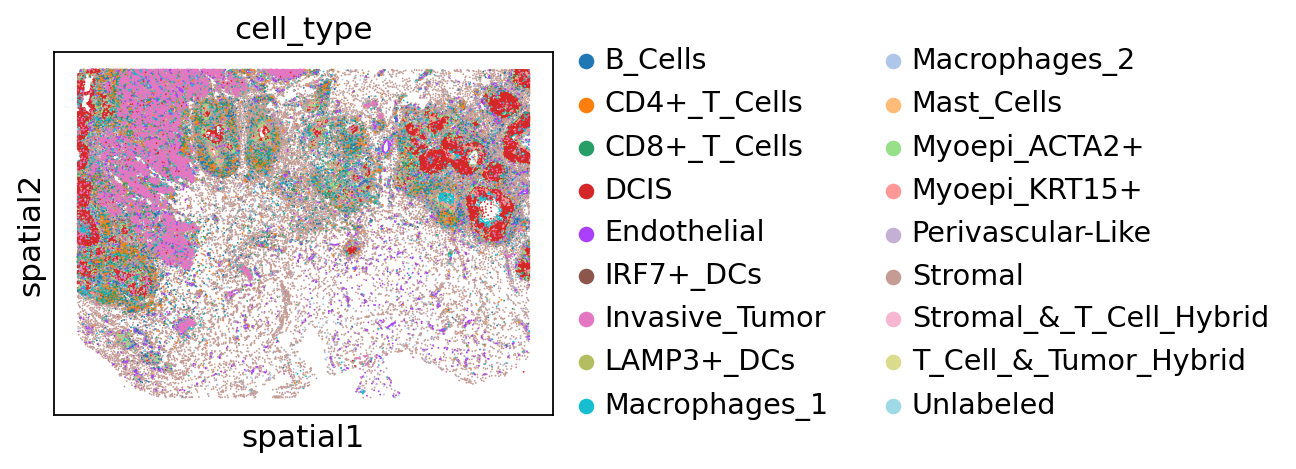

In [6]:
sc.pl.spatial(adata, color="cell_type", spot_size=30)

In [7]:
adata.obs["cell_type"].value_counts()

cell_type
Stromal                    32426
Invasive_Tumor             18185
DCIS                       15993
CD4+_T_Cells                9387
Macrophages_1               8644
CD8+_T_Cells                7493
Endothelial                 7000
B_Cells                     5359
Myoepi_ACTA2+               5324
Myoepi_KRT15+               2636
Macrophages_2               2616
Perivascular-Like            817
Unlabeled                    516
IRF7+_DCs                    454
LAMP3+_DCs                   218
Mast_Cells                   203
Stromal_&_T_Cell_Hybrid       28
T_Cell_&_Tumor_Hybrid          6
Name: count, dtype: int64

## Train NicheVI model

We first define the neighborhood of each cell using a k-nn graph. We set $k=20$. Then, the environment features are defined in two ways - the first is the cell-type composition of its cellular neighborhood. The second is the average gene expression state of neighboring cells, with a separate profile for each of the present cell types. These cell-intrinsic gene expression states are learned with a spatially unaware model, which needs to be trained first.

These computations occur in the `preprocessing_anndata` method, that adds the relevant keys to the AnnData object. 

In [8]:
setup_kwargs = {
    "sample_key": "sample",  # specify column in adata.obs that contains the individual slide ID
    "labels_key": "cell_type",  # specify column in adata.obs that contains the cell type labels
    "cell_coordinates_key": "spatial",  # specify key in adata.obsm that contains the spatial coordinates
    "expression_embedding_key": "X_scANVI",  # specify key in adata.obsm that contains the expression embedding
}

In [ ]:
scvi.external.nicheSCVI.preprocessing_anndata(
    adata,
    k_nn=20, # number of nearest neighbors for spatial graph construction
    **setup_kwargs,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

Saved niche_activation in adata.obsm

Then, as in all scvi-tools model, we need to register the AnnData.

In [10]:
scvi.external.nicheSCVI.setup_anndata(
    adata,
    layer="counts", # specify layer in adata that contains the raw counts
    batch_key="sample", # specify column in adata.obs that contains the batch covariate to correct for
    **setup_kwargs,
)

INFO     Using column names from columns of adata.obsm['niche_composition']                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


We instantiate a NicheVI model. 
Here we highlight a few default parameters: 

-`prior_mixture` indicates whether we want to use a mixture of Gaussian prior for the latent space. \
Default is False, if True, the default number of mixture components is the number of cell types. \
-`linear_classifier` indicates that we use a shallow linear classifier to predict cell types from latent mean. \
-`use_layer_norm="both"` indicates that we use layer normalization in the encoder and decoder. 


In [ ]:
nichevae = scvi.external.nicheSCVI(
    adata,
    prior_mixture=False,
    linear_classifier=True,
    use_layer_norm="both",
    gene_likelihood="nb",
)

nichevae

nicheVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [12]:
nichevae.train(
    max_epochs=400,
    early_stopping=True,
    check_val_every_n_epoch=1,
    batch_size=512,
    plan_kwargs={
        "lr": 5e-4,
    },
)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottlen

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


After training the model, we can compute and store the latent space: 

In [15]:
adata.obsm["X_nicheVI"] = nichevae.get_latent_representation()

We may visualize the latent space in UMAP coordinates, coloring by cell type. 

In [19]:
sc.pp.neighbors(adata, use_rep="X_nicheVI", n_neighbors=30)
sc.tl.umap(adata)

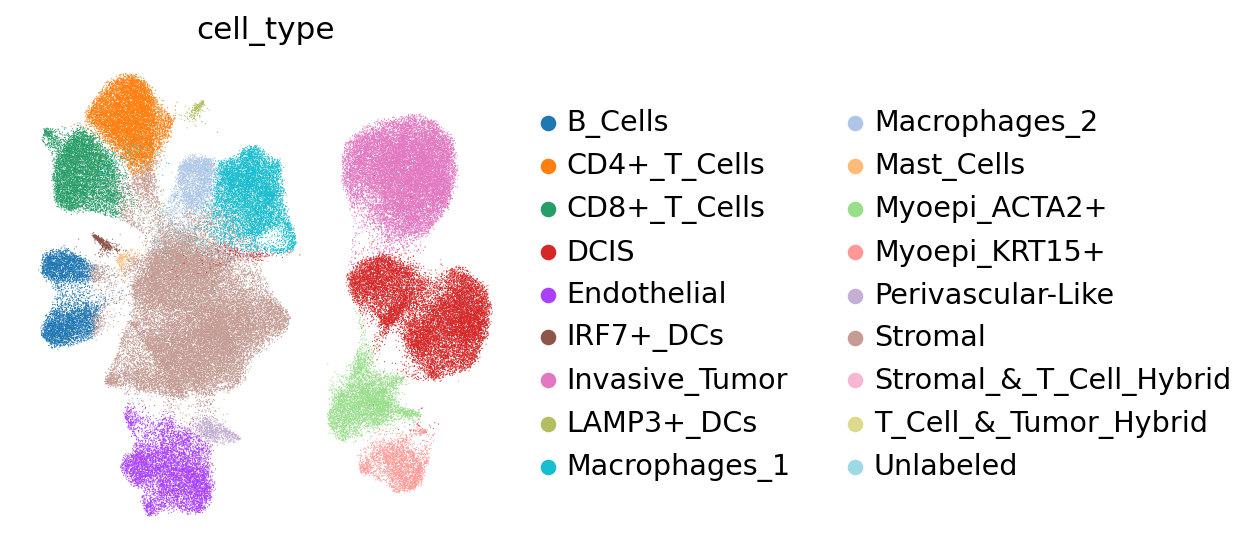

In [20]:
sc.pl.umap(adata, color="cell_type", frameon=False)

# Differential expression analysis

We now use the generative model to test hypotheses of differential expression between the niches. We'll focus on endothelial cells. 

In [17]:
adata_endothelial = adata[adata.obs["cell_type"] == "Endothelial"].copy()
print(adata_endothelial)

AnnData object with n_obs × n_vars = 7000 × 313
    obs: 'sample', 'x', 'y', 'z', 'observed_x', 'observed_y', 'observed_z', 'fov', 'n_counts', 'index', 
'cell_type', '_scvi_batch', '_scvi_labels', '_scvi_sample'
    var: 'mt'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'pca', 'cell_type_colors'
    obsm: 'X_pca', 'X_scANVI', 'spatial', 'niche_indexes', 'niche_distances', 'niche_composition', 
'niche_activation', 'X_nicheVI'
    varm: 'PCs'
    layers: 'counts', 'counts_log1p', 'counts_wo_bg', 'min_max_scaled', 'min_max_scaled_raw'

In [35]:
adata_not_endo = adata[adata.obs["cell_type"] != "Endothelial"].copy()

We perform coarse Leiden clustering on the endothelial latent space, in a bid to find spatially confined populations of endothelial cells.

In [18]:
sc.pp.neighbors(adata_endothelial, use_rep="X_nicheVI", n_neighbors=30)
sc.tl.umap(adata_endothelial)
sc.tl.leiden(
    adata_endothelial, key_added="leiden_nicheVI", resolution=0.3, flavor="igraph", n_iterations=2
)

In [19]:
adata_endothelial.obs["leiden_nicheVI"].unique()  # check the number of clusters

['0', '2', '3', '1', '4']
Categories (5, object): ['0', '1', '2', '3', '4']

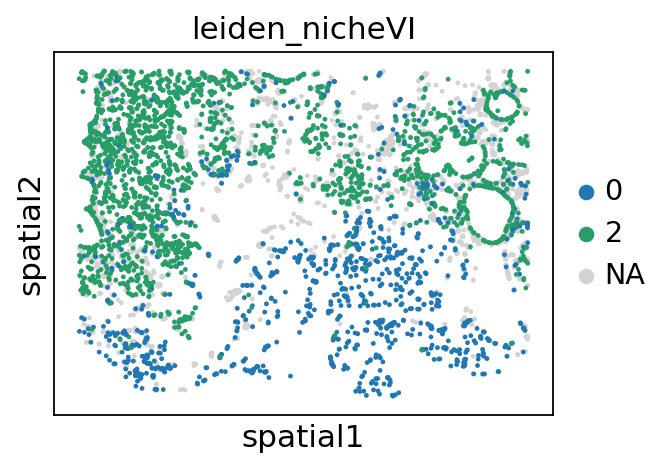

In [23]:
sc.pl.spatial(
    adata_endothelial,
    color="leiden_nicheVI",
    spot_size=80,
    groups=["2", "0"],
    color_map=cc.cm.glasbey_dark,
)

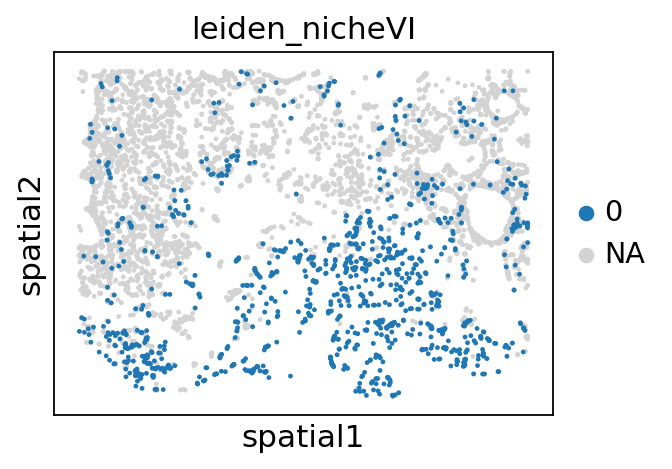

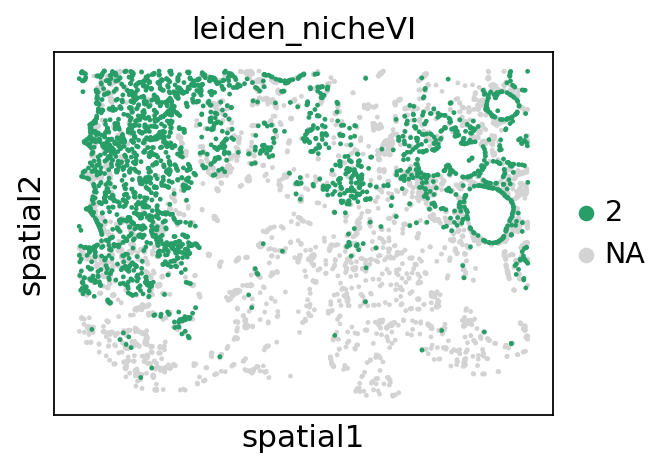

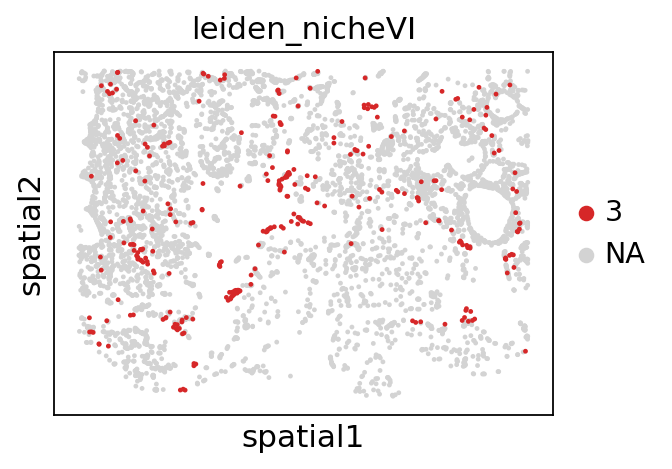

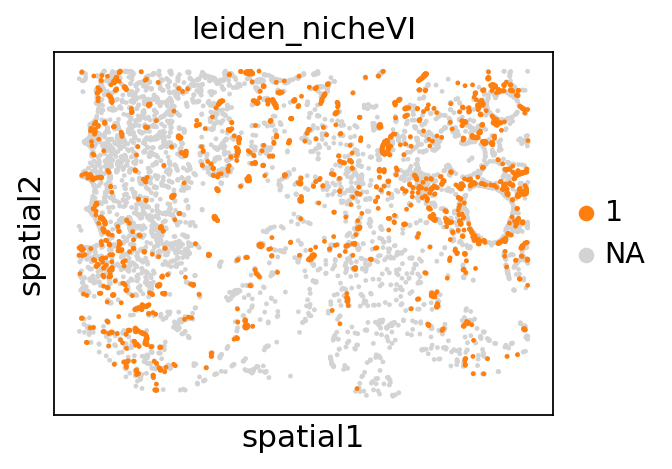

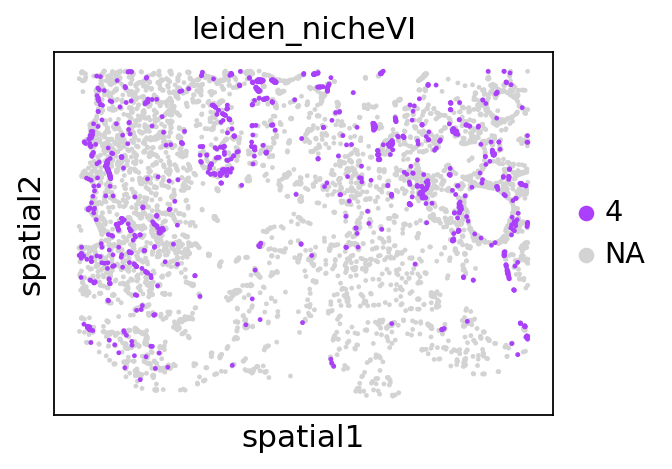

In [21]:
for cluster in adata_endothelial.obs["leiden_nicheVI"].unique():
    sc.pl.spatial(adata_endothelial, color="leiden_nicheVI", spot_size=80, groups=[cluster])

In [22]:
sc.tl.rank_genes_groups(adata_endothelial, groupby="leiden_nicheVI", method="wilcoxon")
marker_dicts = {
    group: sc.get.rank_genes_groups_df(adata_endothelial, group=group).head(20)["names"].tolist()
    for group in adata_endothelial.obs["leiden_nicheVI"].unique()
}
marker_dicts
# sc.pl.rank_genes_groups_df(adata_endothelial, n_genes=20, ncols=5)

{'0': ['ADH1B',
  'PDK4',
  'BTNL9',
  'TIMP4',
  'CAVIN2',
  'LPL',
  'CXCL12',
  'PPARG',
  'ANKRD29',
  'CAV1',
  'ZEB2',
  'ADIPOQ',
  'CLDN5',
  'AKR1C1',
  'CCDC80',
  'FGL2',
  'IGF1',
  'EGFR',
  'DST',
  'CD163'],
 '2': ['KDR',
  'ESM1',
  'CCND1',
  'TCIM',
  'ZEB1',
  'PRDM1',
  'MMP2',
  'PDGFRB',
  'LUM',
  'POSTN',
  'JUP',
  'BTNL9',
  'EDNRB',
  'VOPP1',
  'ERBB2',
  'SVIL',
  'RUNX1',
  'LDHB',
  'SNAI1',
  'CDC42EP1'],
 '3': ['MRC1',
  'CAVIN2',
  'FAM107B',
  'IGF1',
  'ANGPT2',
  'CD9',
  'CCND1',
  'WARS',
  'CCDC80',
  'JUP',
  'MDM2',
  'LRRC15',
  'DUSP5',
  'MMP2',
  'SERPINB9',
  'DST',
  'DSP',
  'TRIB1',
  'FAM49A',
  'POSTN'],
 '1': ['VWF',
  'AQP1',
  'PECAM1',
  'BACE2',
  'FLNB',
  'MMRN2',
  'EDN1',
  'NOSTRIN',
  'SERPINA3',
  'ANKRD29',
  'PDK4',
  'CD93',
  'PTGDS',
  'IL3RA',
  'CAVIN2',
  'DSP',
  'MYLK',
  'WARS',
  'TOMM7',
  'ALDH1A3'],
 '4': ['CXCL12',
  'CAV1',
  'SOX17',
  'CLEC14A',
  'CD93',
  'RAMP2',
  'DST',
  'CD9',
  'PECAM1',
  'MMRN2

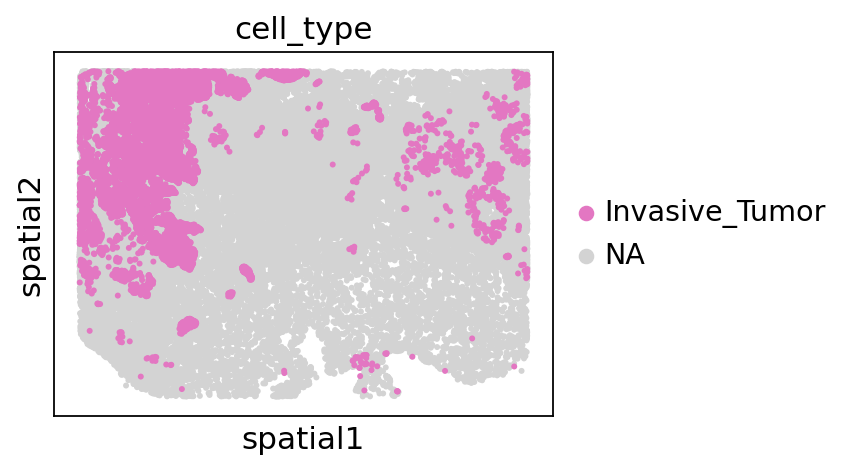

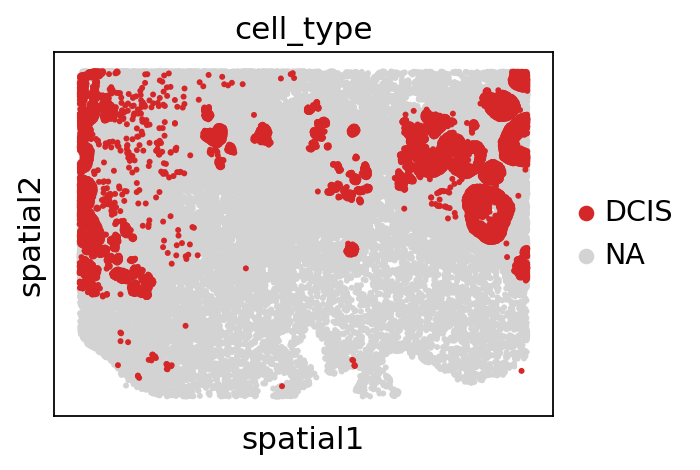

In [36]:
for type in ["Invasive_Tumor", "DCIS"]:
    sc.pl.spatial(adata, color="cell_type", spot_size=100, groups=[type])

In [24]:
adata.obs["max_module"] = "Unknown"
adata.obs.loc[adata.obs["cell_type"] == "Endothelial", "leiden_nicheVI"] = adata_endothelial.obs[
    "leiden_nicheVI"
]

In [25]:
delta_niches = 0.03
delta_markers = 0.15
DELTA = [delta_niches, delta_markers, delta_niches, delta_niches]
FDR = 0.2
G1 = "2"
G2 = "0"
PSEUDO = 1e-4
N_SAMPLES_DE = 1e5
K_NN_DE = 6

DE_1_3 = nichevae.differential_expression(
    adata,
    groupby="leiden_nicheVI",
    group1=G1,
    group2=G2,
    batch_correction=False,
    radius=None,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDO,
)


DE_3_1 = nichevae.differential_expression(
    adata,
    groupby="leiden_nicheVI",
    group1=G2,
    group2=G1,
    batch_correction=False,
    radius=None,
    k_nn=K_NN_DE,
    delta=DELTA,
    niche_mode=True,
    n_samples_overall=N_SAMPLES_DE,
    fdr_target=FDR,
    pseudocounts=PSEUDO,
)

Computing adjusted nearest neighbors...

Using 1 samples

Mean number of neighbors: 3.3 ± 2.1

Computing DE...

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Running DE for group1_group2

Running DE for group1_neighbors1

Running DE for neighbors1_group2

Running DE for neighbors1_neighbors2

Computing g1 confidence scores...

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Computing DE...

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Running DE for group1_group2

Running DE for group1_neighbors1

Running DE for neighbors1_group2

Running DE for neighbors1_neighbors2

Computing g1 confidence scores...

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [71]:
# adata.obs.reset_index(inplace=True)

# # Annotate groups
# adata.obs["group"] = "other"  # Default category
# adata.obs.loc[DE_1_3.n1_index, "group"] = "N1"
# adata.obs.loc[DE_1_3.n2_index, "group"] = "N2"

# sc.pl.spatial(
#     adata,
#     spot_size=40,
#     color=["group"],
#     groups=["N1", "N2"],
#     frameon=False,
#     show=False,
#     use_raw=False,
# )

In [26]:
DE_1_3.gpc

GaussianProcessClassifier(kernel=1**2 * RationalQuadratic(alpha=0.1, length_scale=10),
                          n_restarts_optimizer=10, random_state=0)

In [27]:
DE_1_3.gpc.X_

lfc_median  lfc_median
ESM1       4.829525    0.567219
ADH1B     -4.182565   -4.244343
PCLAF      1.493585    1.306593
VOPP1      0.776773    0.578986
DNTTIP1    0.526078    0.014570
...             ...         ...
DMKN       0.015799    1.232506
CTLA4      0.008494    0.326453
WARS      -0.011173   -0.622041
GPR183    -0.004161    0.684778
TMEM147    0.014997    0.100361

[313 rows x 2 columns]

In [43]:
PROBA_TRES = 0.8
PLOT_MARGIN = 0.2

In [29]:
from scvi.external.nichevi.differential_expression import plot_DE_results

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


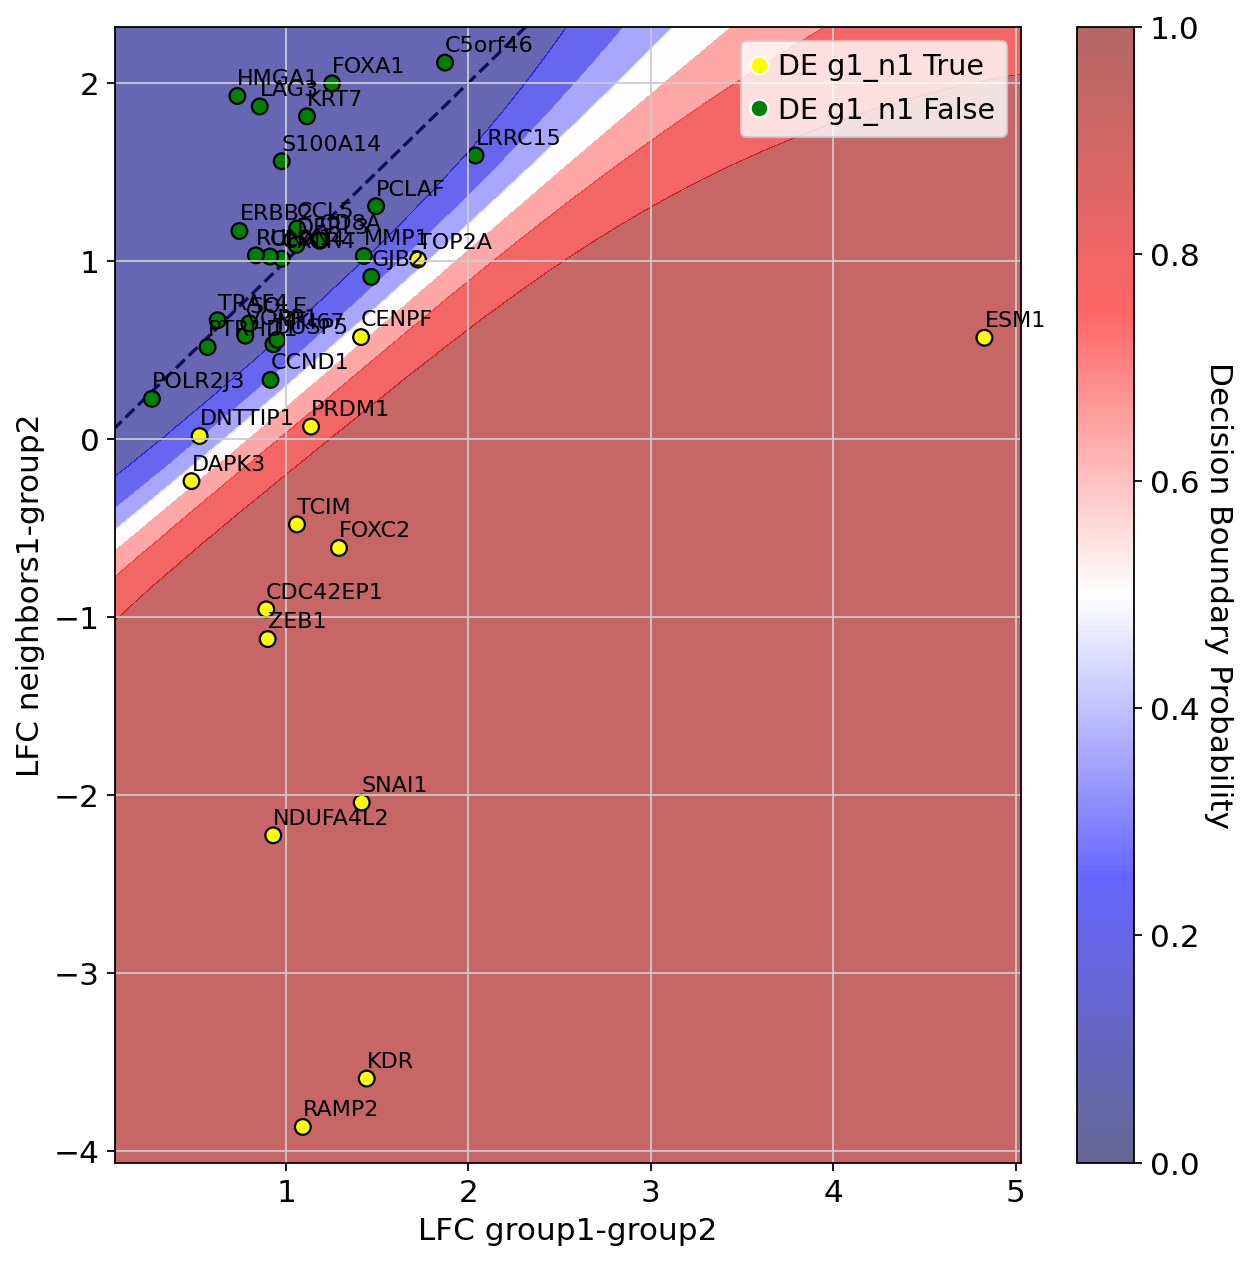

In [44]:
g1_g3_genes = DE_1_3.g1_g2[
    (DE_1_3.g1_g2["lfc_median"] > 0) & (DE_1_3.g1_g2["proba_de"] > PROBA_TRES)
].index

plot_DE_results(
    DE_1_3.gpc,
    filter=g1_g3_genes,
    # path_to_save=f"{setup.FIGURES_2DE_FOLDER}scatter_DE_proseg.svg",
    margin=PLOT_MARGIN,
    # manual_limits=(-0.5, 5.5, -6.25, 4),
)

In [33]:
yellow_genes_g1_g2 = DE_1_3.gpc.confident_genes
blue_genes_g1_g2 = list(set(g1_g3_genes) - set(yellow_genes_g1_g2))

In [34]:
def get_gene_percentiles_list(adata, gene_list, p, layer=None):
    """
    Calculate the p-percentile of gene expression for a list of genes in an AnnData object.

    Parameters
    ----------
        adata (AnnData): The AnnData object containing expression data.
        gene_list (list): List of gene names for which to compute percentiles.
        p (float): Percentile to compute (between 0 and 100).
        layer (str or None): The layer from which to retrieve expression data.
                             If None, uses `adata.X`.

    Returns
    -------
        list: A list of p-percentile values for the genes, in the same order as gene_list.
              If a gene is not found, its value will be `None`.
    """
    percentiles = []

    for gene in gene_list:
        if gene in adata.var_names:
            if layer:
                data = adata[:, gene].layers[layer].flatten()
            else:
                data = adata[:, gene].X.flatten()

            # Compute the percentile
            percentiles.append(np.percentile(data, p))
        else:
            percentiles.append(None)  # Handle genes not in adata.var_names

    return percentiles

[<Axes: title={'center': 'ESM1'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'KRT7'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'FOXA1'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'KDR'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'SNAI1'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'NDUFA4L2'}, xlabel='spatial1', ylabel='spatial2'>]

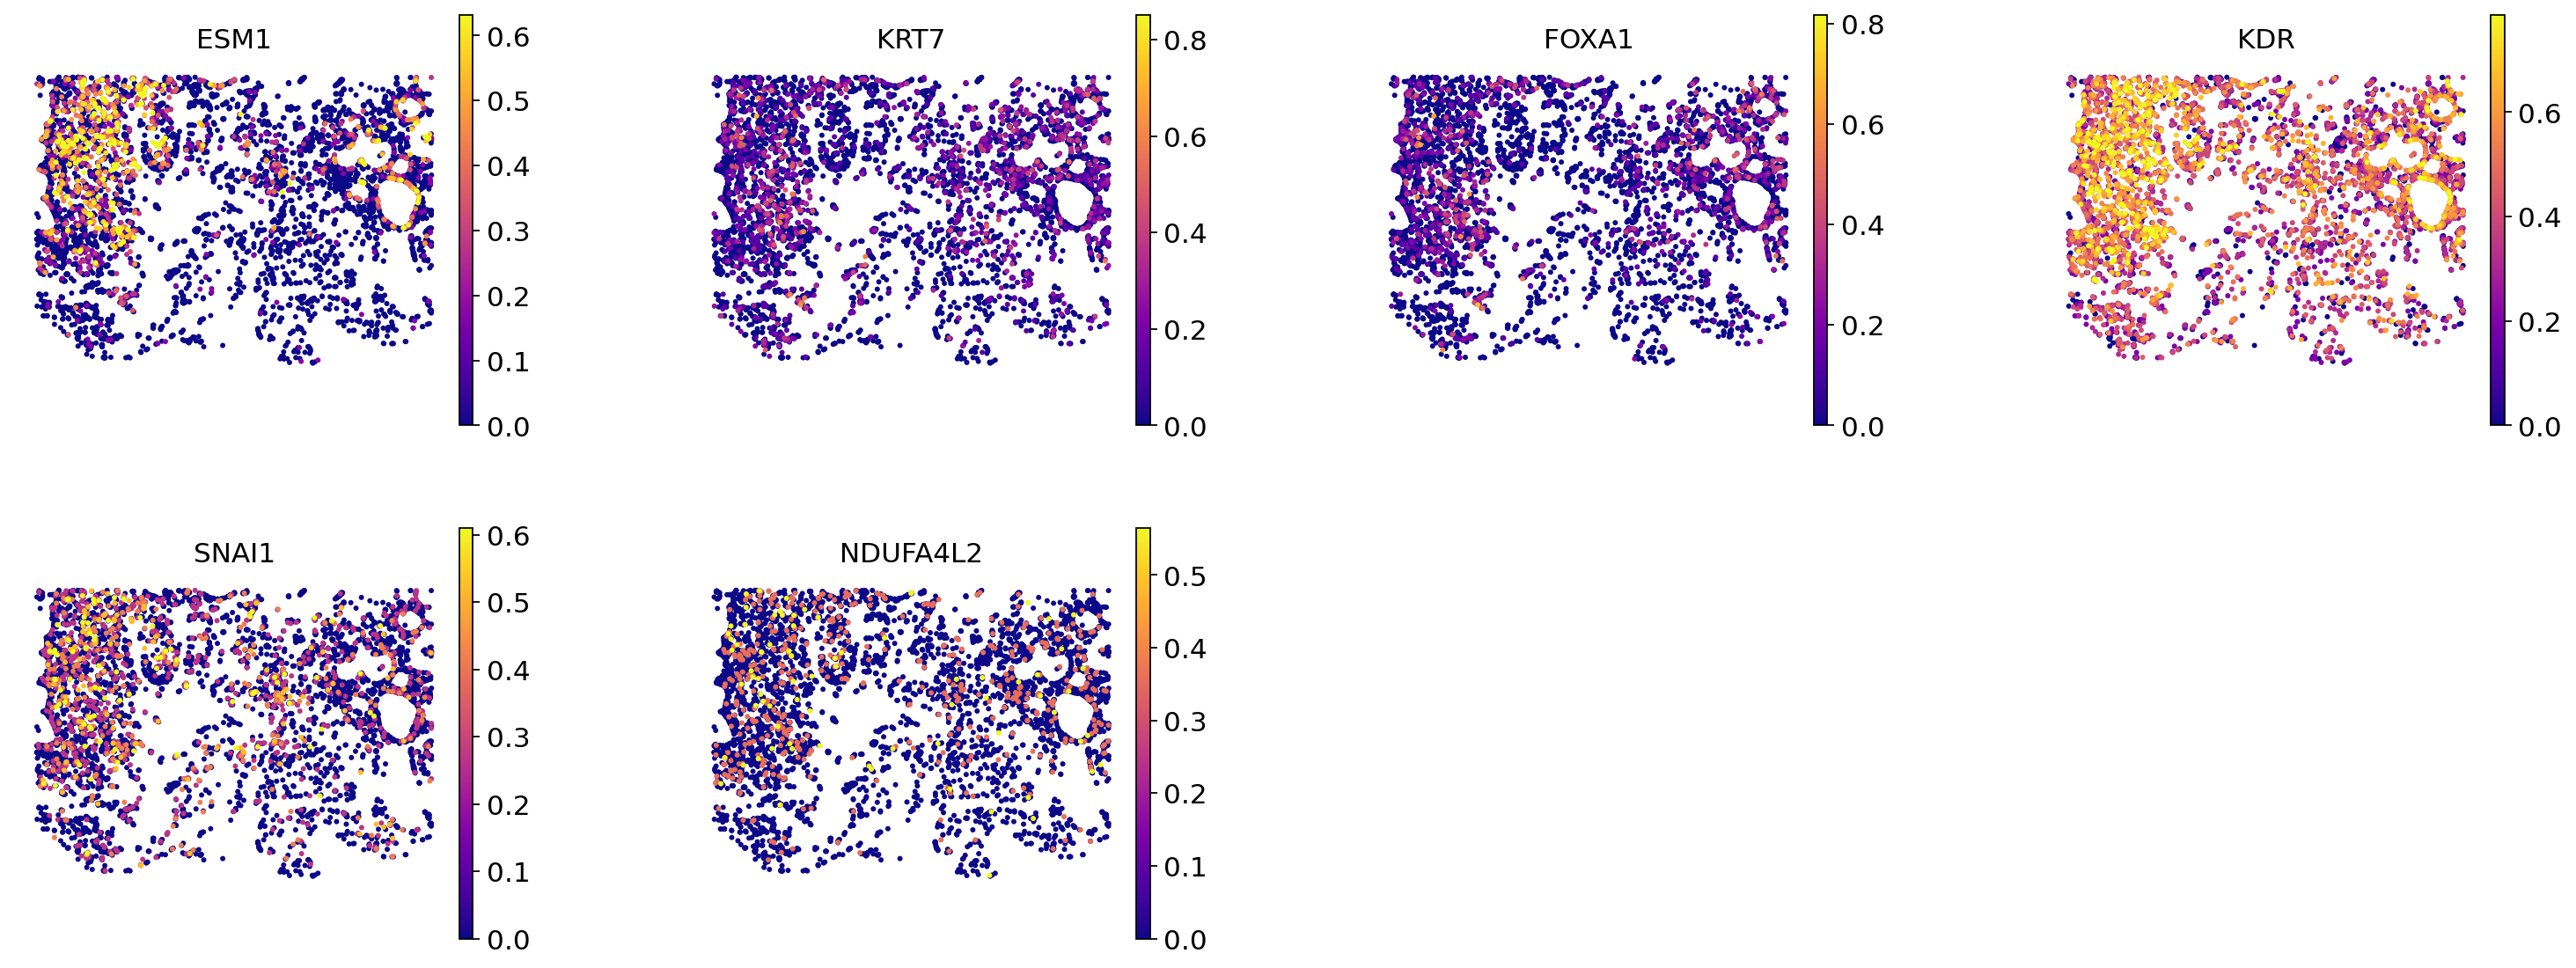

In [ ]:
plot_endo = True
gene_list_invasive = ["ESM1", "KRT7", "FOXA1", "KDR", "SNAI1", "NDUFA4L2"]
percentiles_invasive = get_gene_percentiles_list(
    adata, gene_list_invasive, 99.9, layer="min_max_scaled"
)

sc.pl.spatial(
    adata=adata_endothelial
    if plot_endo
    else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_invasive,
    frameon=False,
    show=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_invasive,
    layer="min_max_scaled",
    cmap="plasma",
)

/home/nathanl/miniforge3/envs/scvi/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianProcessClassifier was fitted with feature names
  warnings.warn(


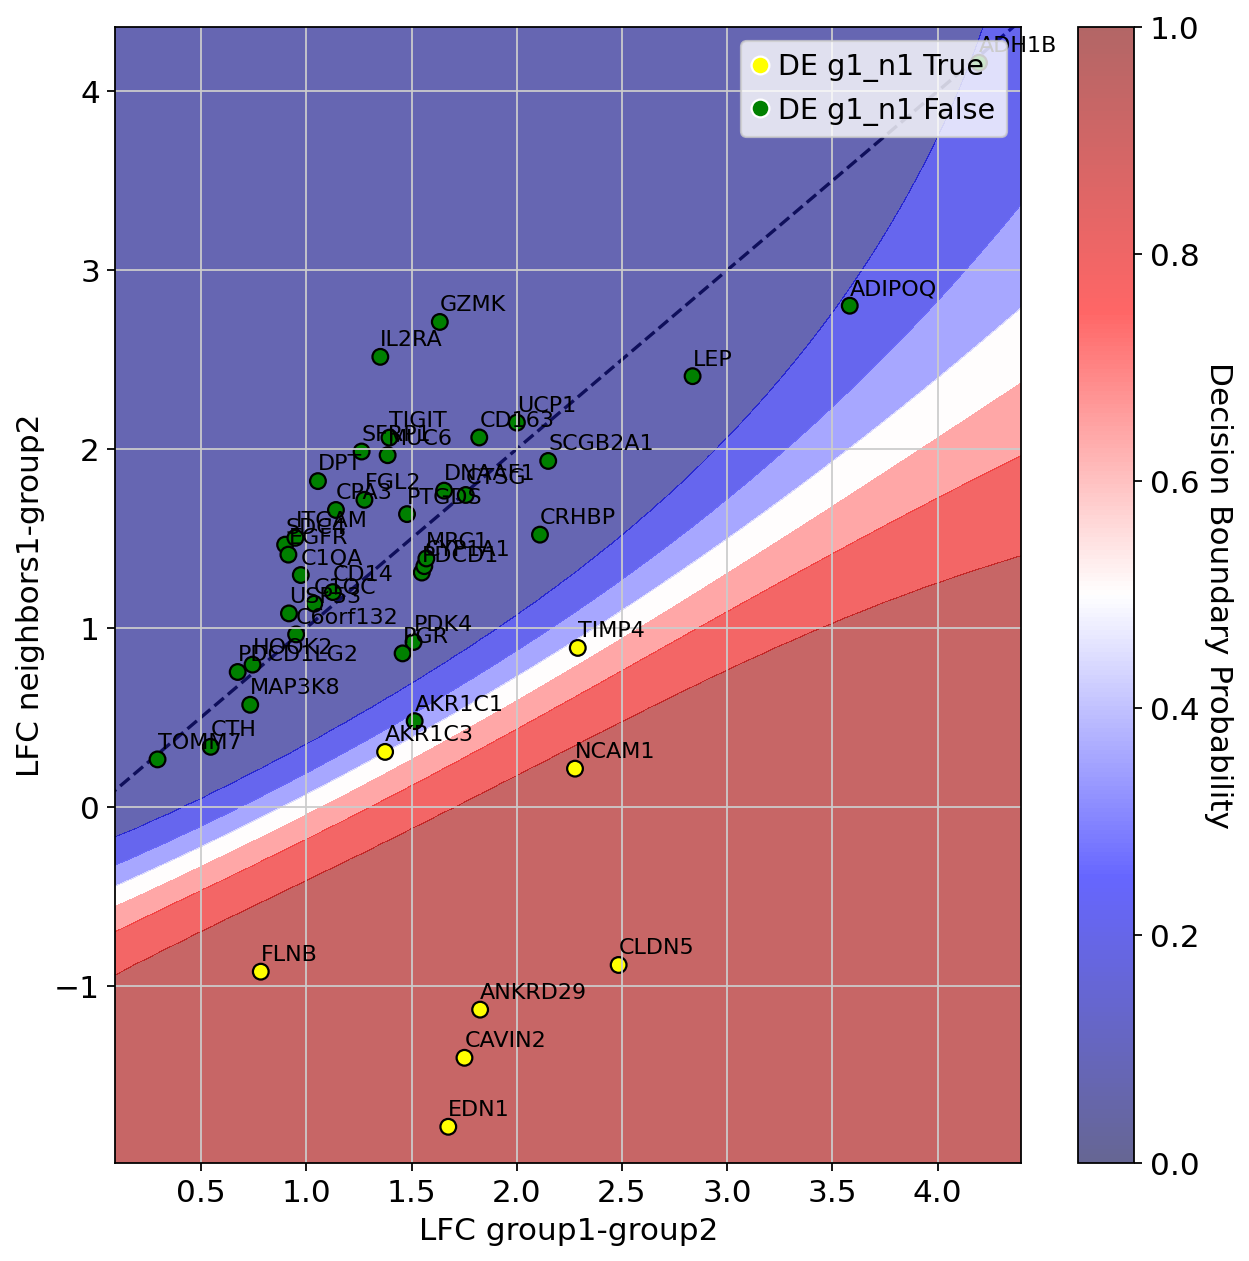

In [38]:
g3_g1_genes = DE_3_1.g1_g2[
    (DE_3_1.g1_g2["lfc_median"] > 0) & (DE_3_1.g1_g2["proba_de"] > PROBA_TRES)
].index

plot_DE_results(
    DE_3_1.gpc,
    filter=g3_g1_genes,
    # path_to_save=f"{setup.FIGURES_2DE_FOLDER}scatter_DE_3_1_proseg.svg",
    margin=PLOT_MARGIN,
    # manual_limits=(-0, 5.0, -3.5, 5),
)

In [39]:
yellow_genes_g2_g1 = DE_3_1.gpc.confident_genes
blue_genes_g2_g1 = list(set(g3_g1_genes) - set(yellow_genes_g2_g1))

[<Axes: title={'center': 'EDN1'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'CAVIN2'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'CLDN5'}, xlabel='spatial1', ylabel='spatial2'>]

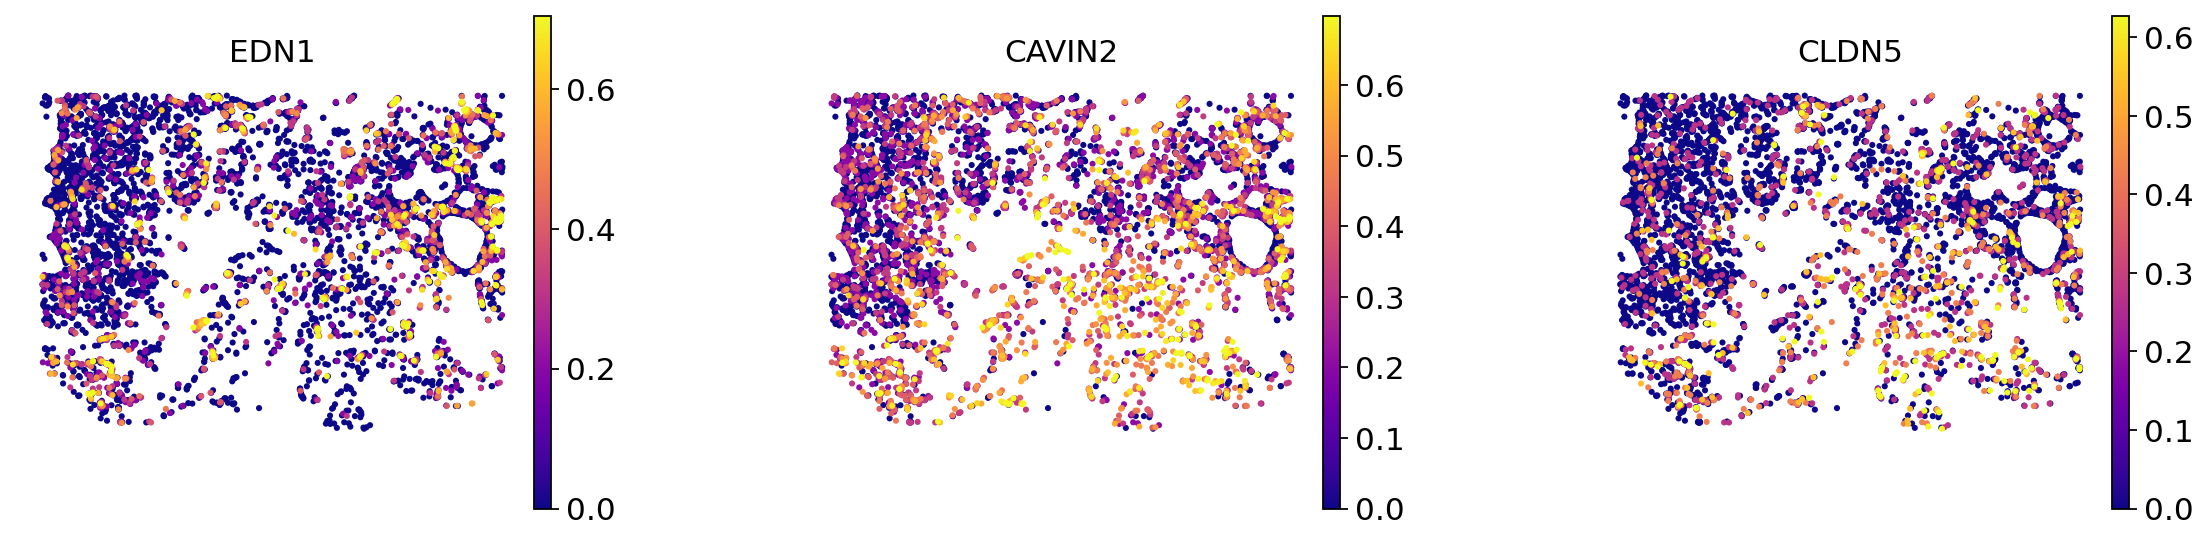

In [40]:
plot_endo = True
gene_list_stroma = ["EDN1", "CAVIN2", "CLDN5"]
percentiles_stroma = get_gene_percentiles_list(
    adata, gene_list_stroma, 99.9, layer="min_max_scaled"
)

sc.pl.spatial(
    adata=adata_endothelial
    if plot_endo
    else adata_not_endo,
    spot_size=100 if plot_endo else 40,
    color=gene_list_stroma,
    frameon=False,
    show=False,
    use_raw=False,
    wspace=0.4,
    vmax=percentiles_stroma,
    layer="min_max_scaled",
    cmap="plasma",
)